# LANL Earthquake Prediction
Can you predict upcoming laboratory earthquakes?  

## Tags
* physics
* signal processing
* earth sciences
* mae
* large

In [1]:
# Inconsistent Sampling Times?
# https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/89151#latest-515558

# Interesting insight from shuffling ?
# https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/89366

# Simple way to boost your score ?
# https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/89513#latest-517993

# https://www.kaggle.com/nikitagribov/seismic-signal-eda-analysis-function
# https://www.kaggle.com/taqanori/trying-mfcc-mel-frequency-cepstral-coefficients
# https://www.kaggle.com/bigironsphere/rock-music-frequency-eda-fe-via-lomb-scargle

In [2]:
RANDOM_SEED = 2019

from collections import Counter
import numpy as np
from numpy.random import seed
seed(RANDOM_SEED)
from scipy.spatial import distance
import pandas as pd
pd.options.display.precision = 12
import dask
import dask.dataframe as dd

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from plotly import tools
import plotly.figure_factory as ff

from bokeh.layouts import column, row
from bokeh.plotting import Figure, show
from bokeh.io import output_notebook
from bokeh.models import PrintfTickFormatter
from bokeh.models import LinearAxis, Range1d

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import os
import glob
from IPython.display import display
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
import gc
gc.enable()

In [178]:
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
seg_nrows = 150_000
samples = 4096 #buffer
logging_delay = 1.1e-9 #recording
jump = 1e-3 #send (Host says 12us)
T_meter = 250e-6 #4MHz
host_gap = 12e-6

actual_time_a_batch = (samples * logging_delay) + jump
actual_seg_total_time = (seg_nrows // samples * actual_time_a_batch) + (seg_nrows % samples * logging_delay)

print(f"""
    {actual_time_a_batch:.2e} sec
    {actual_seg_total_time:.2e} sec
    {actual_seg_total_time // T_meter} times
""")


    1.00e-03 sec
    3.62e-02 sec
    144.0 times



In [4]:
_T_meter = T_meter
resampling_rate = 0 #picking rows interval

while _T_meter > 0:
    resampling_rate += 1
    _T_meter -= logging_delay
    
    if 0 == (resampling_rate % samples):
        _T_meter -= jump
    
print(resampling_rate)

4096


In [5]:
aco = pd.read_csv(
    "../input/train.csv",  
    dtype={
        'acoustic_data': np.float64, 
        'time_to_failure': np.float64
    },
    #usecols=['acoustic_data'],
    engine='c',
    nrows=150_000
)

print(aco.time_to_failure.values[0]-T_meter, aco.time_to_failure.values[-1])
print(aco.time_to_failure.values[0]-T_meter > aco.time_to_failure.values[-1])

1.4688499832 1.4307971859
True


In [6]:
pd.options.display.precision = 10
aco[:10]

,acoustic_data,time_to_failure
0,12.0,1.4690999832
1,6.0,1.4690999821
2,8.0,1.4690999810
3,5.0,1.4690999799
4,8.0,1.4690999788
5,8.0,1.4690999777
6,9.0,1.4690999766
7,7.0,1.4690999755
8,-5.0,1.4690999744
9,3.0,1.4690999733


# ↓↓↓      important !!!　↓↓↓

In [261]:
for idx, d in aco.time_to_failure.items():
    if 1.4690999832-T_meter > d:
        print(idx)
        print(1.4690999832-T_meter - d)
        break

4095
0.0007499988999999374


In [158]:
np.diff(aco.time_to_failure.values)[:10]

array([-1.09999987e-09, -1.10000031e-09, -1.09999965e-09, -1.10000031e-09,
       -1.09999987e-09, -1.10000009e-09, -1.09999987e-09, -1.10000009e-09,
       -1.09999987e-09, -1.10000009e-09])

In [229]:

print(aco.time_to_failure.values[4094], aco.time_to_failure.values[8190])
print(f"{np.round(aco.time_to_failure.values[20478]-aco.time_to_failure.values[20479],12):.3e}")
print(f"{np.round(aco.time_to_failure.values[8180]-aco.time_to_failure.values[8181],12):.3e}")
print(f"{np.round(aco.time_to_failure.values[20478]-aco.time_to_failure.values[20479],12):.3e}")

1.4690954798 1.4680954797999999
1.095e-03
1.100e-09
1.095e-03


In [231]:
l = []
l_val = []
jump = []
for i, val in enumerate(np.diff(aco.time_to_failure.values)):
    
    if -host_gap > val:
        l.append(i)
        l_val.append(val)
    #1ms jump
    if -1e-3 > val:
        jump.append(i)

display(
    pd.merge(
        pd.DataFrame(
            {
                "idx": l,
                "delay_interval": np.insert([0], 1, np.diff(l)),
                "val": l_val
            }
        ),
        pd.DataFrame(
            {
                "idx":jump,
                "jump_interval": np.insert([0], 1, np.diff(jump))
            }
        ),
        on='idx',
        how='left'
    )
)


,delay_interval,idx,val,jump_interval
0,0,4094,-0.0009954955,NaN
1,4096,8190,-0.0010954955,0.0
2,4096,12286,-0.0010954955,4096.0
3,4096,16382,-0.0009954955,NaN
4,4096,20478,-0.0010954955,8192.0
5,4096,24574,-0.0009954955,NaN
6,4096,28670,-0.0010954955,8192.0
7,4096,32766,-0.0010954955,4096.0
8,4096,36862,-0.0009954955,NaN
9,4096,40958,-0.0010954955,8192.0


In [86]:
Counter(np.round(aco.time_to_failure.values, 5))

Counter({1.4308: 2545,
         1.4319: 4096,
         1.433: 4096,
         1.434: 4096,
         1.4351: 4096,
         1.4362: 4096,
         1.4372: 4096,
         1.4383: 4096,
         1.4393: 4096,
         1.4404: 4096,
         1.4415: 4096,
         1.4425: 4096,
         1.4436: 4096,
         1.4447: 4096,
         1.4457: 4096,
         1.4468: 4096,
         1.4479: 4096,
         1.4489: 4096,
         1.45: 4096,
         1.4511: 4096,
         1.4521: 4096,
         1.4532: 4096,
         1.4542: 4096,
         1.4553: 4096,
         1.4564: 4096,
         1.4574: 4096,
         1.4585: 4096,
         1.4596: 4096,
         1.4606: 4096,
         1.4617: 4096,
         1.4628: 4096,
         1.4638: 4096,
         1.4649: 4096,
         1.4659: 4096,
         1.467: 4096,
         1.4681: 4096,
         1.4691: 4095})

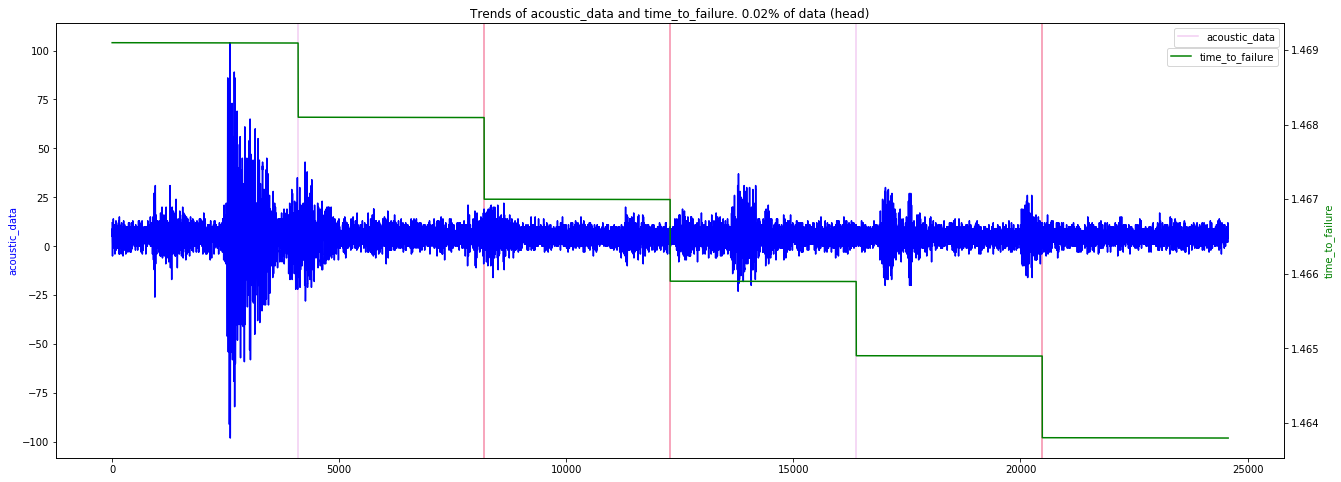

In [208]:
fig, ax1 = plt.subplots(figsize=(22, 8))
plt.title("Trends of acoustic_data and time_to_failure. 0.02% of data (head)")

for i, val in enumerate(np.diff(aco.time_to_failure.values[:24574])):
    
    if -host_gap > val:
        plt.axvline(x=i, alpha=0.2, color='m')
    #1ms jump
    if -1e-3 > val:
        plt.axvline(x=i, alpha=0.3, color='r')
        
plt.plot(aco.acoustic_data.values[:24574], color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(aco.time_to_failure.values[:24574], color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.905, 0.9))
        
plt.grid(False)

In [186]:
display(aco.time_to_failure.values)

array([1.46909998, 1.46909998, 1.46909998, ..., 1.43079719, 1.43079719,
       1.43079719])

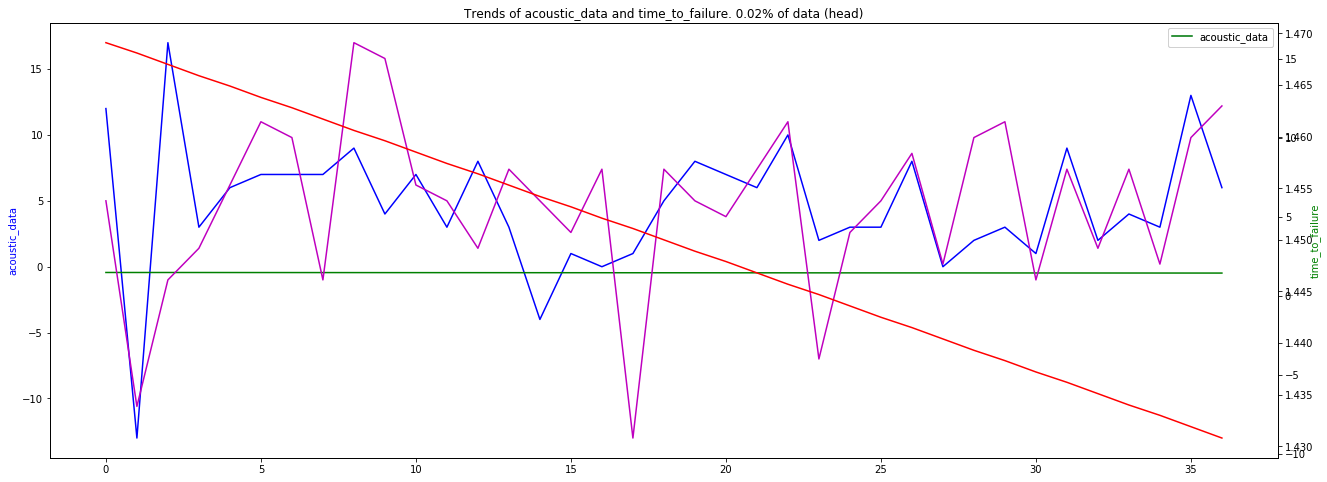

In [285]:
fig, ax1 = plt.subplots(figsize=(22, 8))
plt.title("Trends of acoustic_data and time_to_failure. 0.02% of data (head)")

        
plt.plot(aco.acoustic_data.values[::4095], color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(aco.time_to_failure.values[::4095], color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.905, 0.9))
        
plt.plot(aco.acoustic_data.values[1::4096], color='m')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(aco.time_to_failure.values[1::4096], color='r')
        
plt.grid(False)

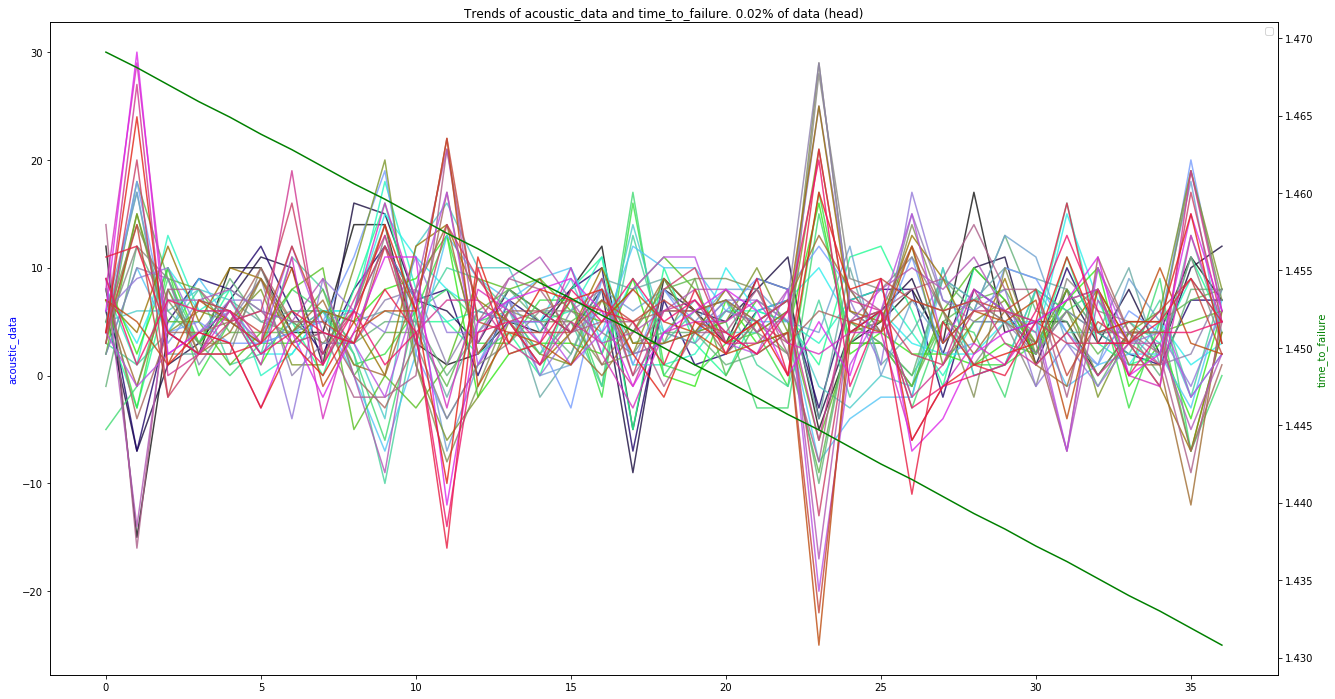

In [314]:
pad = 0x111111
n = 40

fig, ax1 = plt.subplots(figsize=(22, 12))
plt.title("Trends of acoustic_data and time_to_failure. 0.02% of data (head)")
        
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])

for i, color in enumerate(range(pad, 0xFFFFFF-pad, (0xFFFFFF-pad)//n)):
    plt.plot(aco.acoustic_data.values[i::4096], color=hex(color).replace('0x','#'), alpha=0.8)
        

ax2 = ax1.twinx()
ax2.set_ylabel('time_to_failure', color='g')
plt.plot(aco.time_to_failure.values[::4096], color='g')

plt.grid(False)

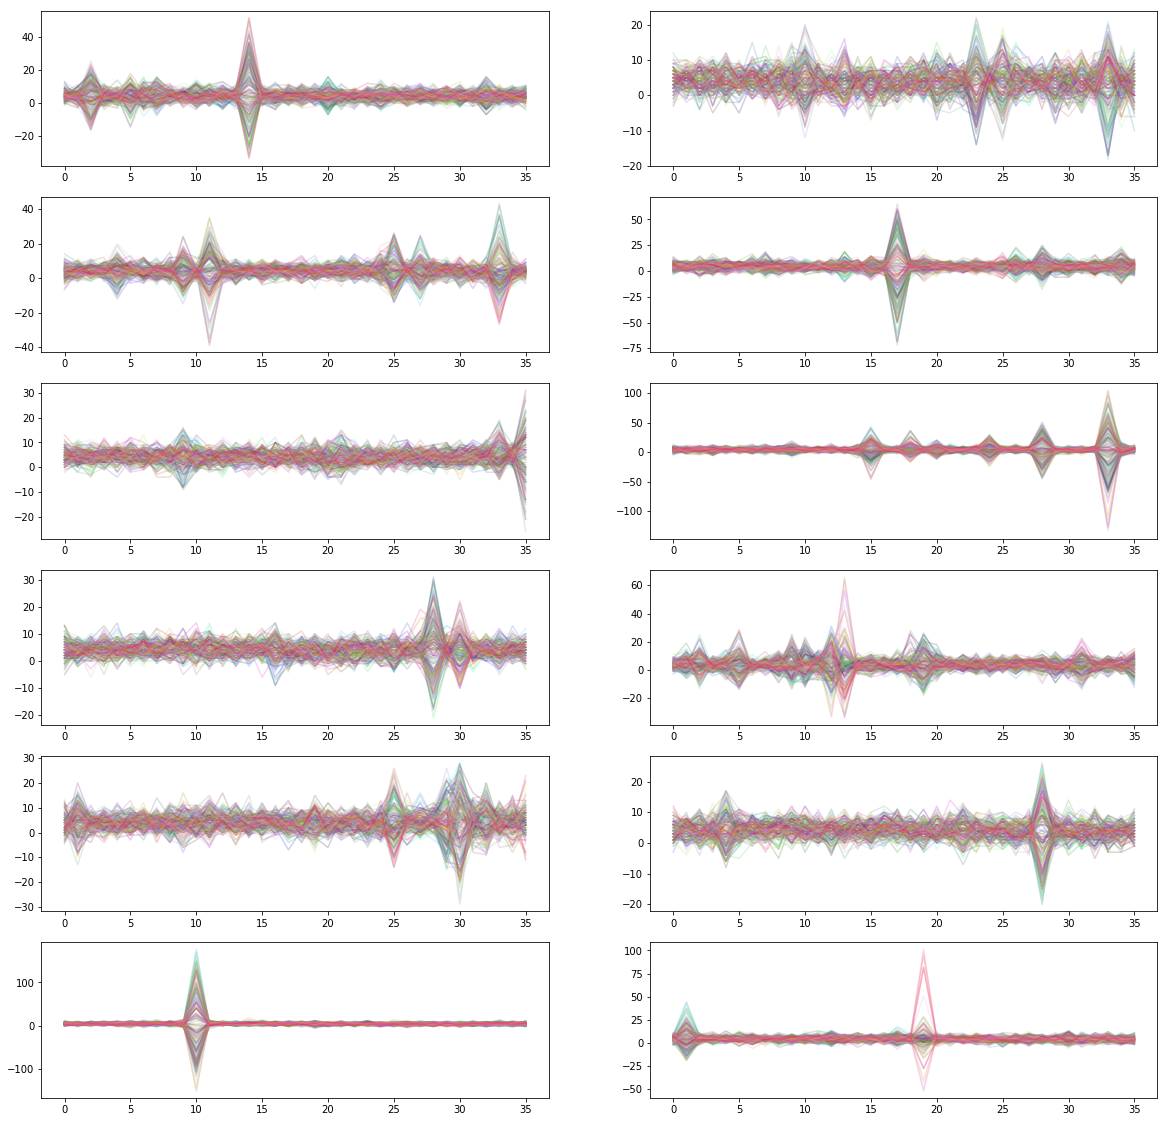

In [8]:
path = '../input/test/*.csv'
tests = glob.glob(path)

start_idx = 150_000 % 4096
pad = 0x111111
nplots = 160
nfig = 12
nrows = nfig//2

fig, ax = plt.subplots(nrows, 2, figsize=(20, 20))
plt.grid(False)

for _id, f_path in enumerate(np.random.choice(tests, size=nfig)):
    
    test = pd.read_csv(
        f_path,  
        dtype={
            'acoustic_data': np.float64, 
        },
        engine='c'
    )
    
    for i, color in enumerate(range(pad, 0xFFFFFF-pad, (0xFFFFFF-pad)//nplots)):
        ax[_id%nrows, _id//nrows].plot(test.acoustic_data.values[start_idx+i::4096], color=hex(color).replace('0x','#'), alpha=0.2)

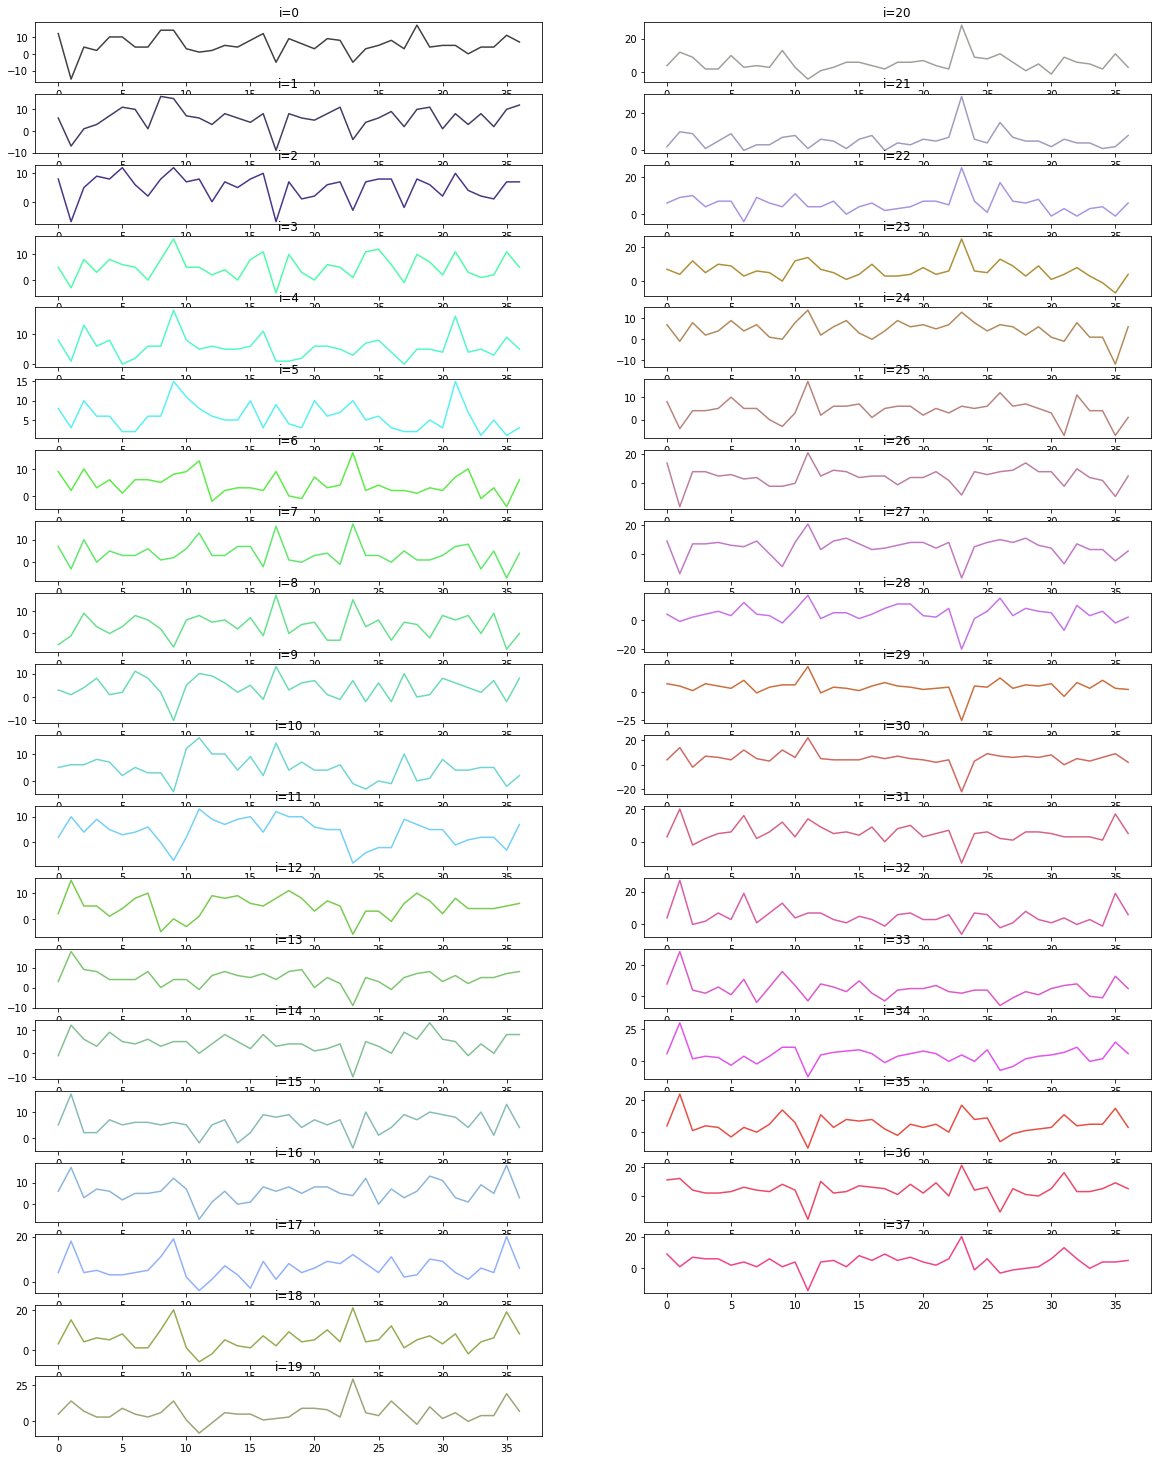

In [328]:
n = 40
nrows = n // 2

fig, ax = plt.subplots(nrows, 2, figsize=(20, 26))
plt.grid(False)
ax[18, 1].axis('off')
ax[19, 1].axis('off')

for i, color in enumerate(range(pad, 0xFFFFFF-pad, (0xFFFFFF-pad)//n)):
    ax[i%nrows, i//nrows].set_title(f"i={i}")
    ax[i%nrows, i//nrows].plot(aco.acoustic_data.values[i::4096], color=hex(color).replace('0x','#'), alpha=0.8)    

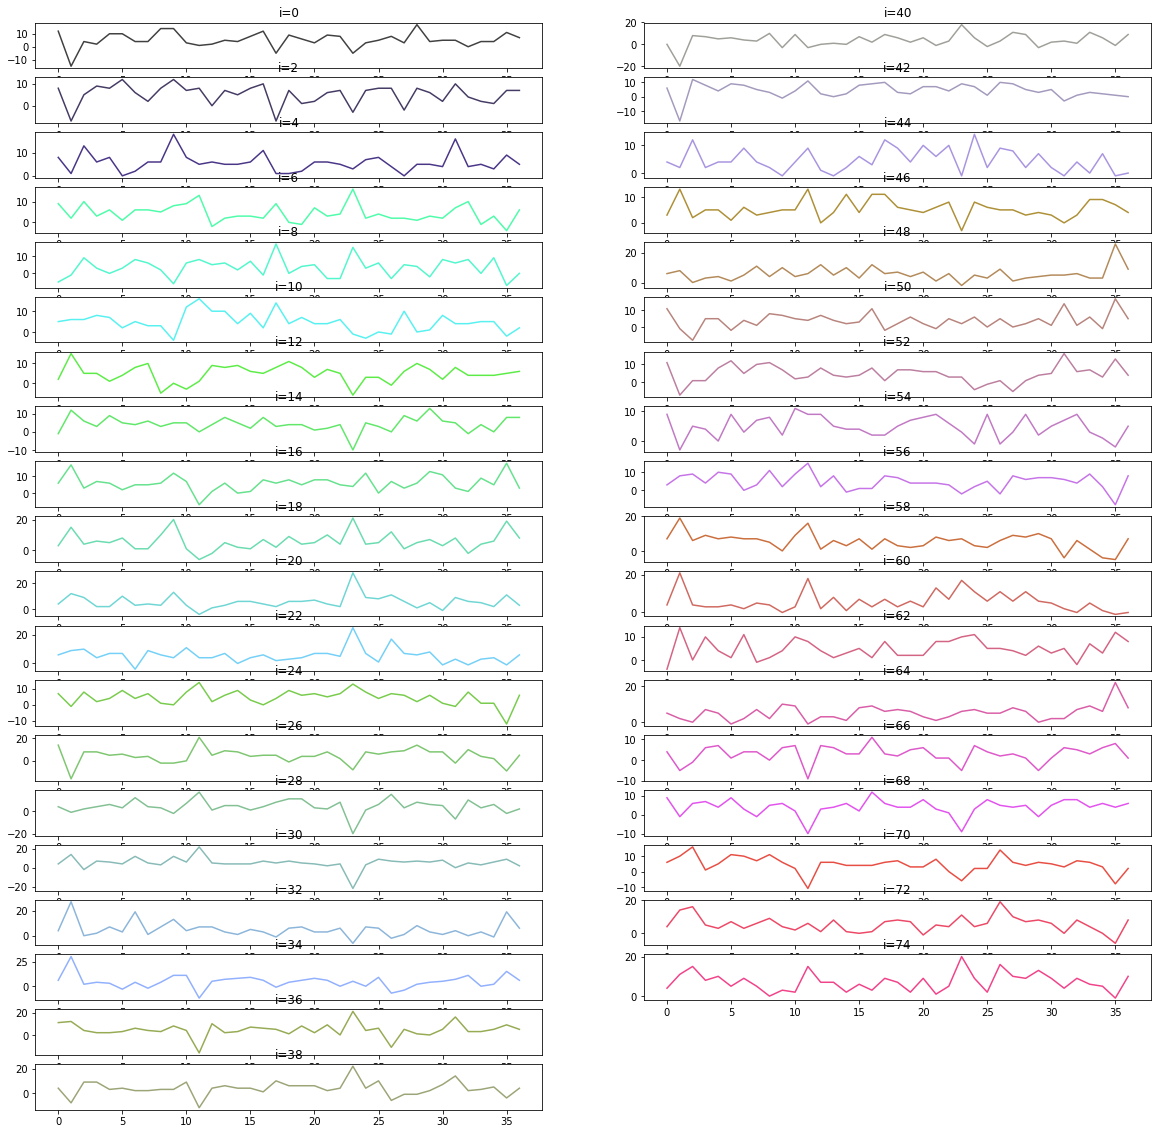

In [329]:
pad = 0x111111
n = 40
nrows = n // 2

fig, ax = plt.subplots(nrows, 2, figsize=(20, 20))
plt.grid(False)
ax[18, 1].axis('off')
ax[19, 1].axis('off')


for i, color in enumerate(range(pad, 0xFFFFFF-pad, (0xFFFFFF-pad)//n)):
    ax[i%nrows, i//nrows].set_title(f"i={i*2}")
    ax[i%nrows, i//nrows].plot(aco.acoustic_data.values[i*2::4096], color=hex(color).replace('0x','#'), alpha=0.8)

* 12cycle
* Similar waveform next to each other

# Suggest

* Predict 2544 (150_000 % 4096) missing data
* Modeling sensor placement OR experiment environment
* Clustering
* Min-Max scaler
* Time-space eigenvalue decomposition
* Make time-series predicting model (like ARMA) and use parameters as feature
* Resampling and any signal processing
* Hashing
* CNN with graphical chart (c.g. [Seizure detection by convolutional neural network-based analysis of scalp electroencephalography plot images](https://www.sciencedirect.com/science/article/pii/S2213158219300348?via%3Dihub))

Hmm...

# Let's detect batch !!!
LOL :)

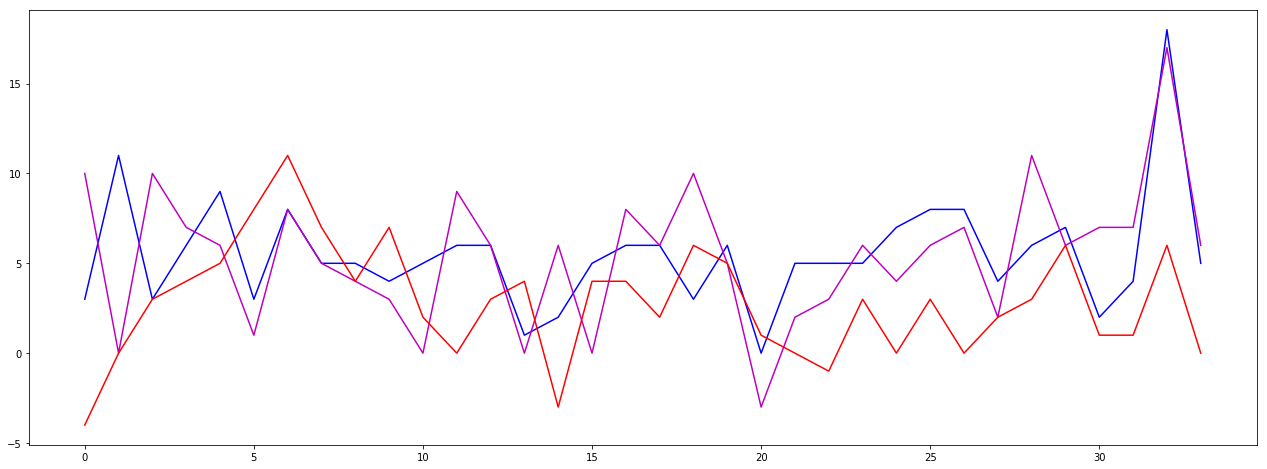

In [339]:
fig, ax1 = plt.subplots(figsize=(22, 8))

plt.plot(aco.acoustic_data.values[12285::4096], color='b')
plt.plot(aco.acoustic_data.values[12286::4096], color='m')
plt.plot(aco.acoustic_data.values[12287::4096], color='r')
        
plt.grid(False)

In [16]:
print(
    calc_distances(aco.acoustic_data.values[12285::4096], aco.acoustic_data.values[12286::4096]),
    calc_distances(aco.acoustic_data.values[12286::4096], aco.acoustic_data.values[12287::4096])
)

[0.16109342067273535, 21.633307652783937, 1.4075187969924812] [0.4130242607999176, 31.622776601683793, 1.9440791354565727]


In [12]:
dis_cos_next = []
end_idx = 150_000 - 150_000 % 4096

for i in range(4096-1):
    dis_cos_next.append(distance.cosine(aco.acoustic_data.values[:end_idx][i::4096], aco.acoustic_data.values[:end_idx][i+1::4096]))

dis_cos_next = np.round(np.array(dis_cos_next), 3)

display(dis_cos_next)
display(np.argmax(dis_cos_next))

array([0.103, 0.087, 0.083, ..., 0.073, 0.134, 0.588])

4094

In [349]:
dis_cos_next = []

for i in range(4096-1):
    dis_cos_next.append(distance.cosine(aco.acoustic_data.values[start_idx:][i::4096], aco.acoustic_data.values[start_idx:][i+1::4096]))

dis_cos_next = np.round(np.array(dis_cos_next), 3)

display(dis_cos_next)
display(start_idx + np.argmax(dis_cos_next))

array([0.025, 0.034, 0.022, ..., 0.108, 0.101, 0.101])

4094

In [362]:
distance.cosine(test.acoustic_data.values[start_idx-1:][i+1::4096], test.acoustic_data.values[start_idx-1:][(i+1)+1::4096])

0.1312812734056088

In [90]:
aco = pd.read_csv(
    "../input/train.csv",  
    dtype={
        'acoustic_data': np.float64, 
        'time_to_failure': np.float64
    },
    #usecols=['acoustic_data'],
    engine='c',
    nrows=1200_000
)

In [77]:
from sklearn import metrics

def calc_distances(a, b):
    return [distance.cosine(a, b), distance.euclidean(a, b), 1-metrics.r2_score(a, b)]

In [88]:
np.set_printoptions(linewidth=200)

In [110]:
for pad in np.random.randint(0, high=1200_000-seg_nrows-1, size=5):
    print(pad)
    print(f"Correct: {4096-(((pad + 4096) - 4094) % 4096)}")
    
    distances = []
    
    for i in range(4096-1):
        distances.append(
            calc_distances(
                aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][i::4096], 
                aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][i+1::4096]
            )
        )
        
    distances.append(
        calc_distances(
            aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx+1][i+1::4096], 
            aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx+1][(i+1)+1::4096]
        )
    )
    
    breakpoints_0 = np.argsort(np.array(distances).T)[:,::-1][:,:20]
    
    distances = []
    
    for i in range(4096-1):
        distances.append(
            calc_distances(
                aco.acoustic_data.values[pad:pad+seg_nrows][start_idx:][i::4096], 
                aco.acoustic_data.values[pad:pad+seg_nrows][start_idx:][i+1::4096]
            )
        )
        
    distances.append(
        calc_distances(
            aco.acoustic_data.values[pad:pad+seg_nrows][start_idx-1:][i+1::4096], 
            aco.acoustic_data.values[pad:pad+seg_nrows][start_idx-1:][(i+1)+1::4096]
        )
    )
    
    breakpoints_1 = (start_idx + np.argsort(np.array(distances).T)[:,::-1][:,:20]) % 4096
    
    print(breakpoints_0, '\n',breakpoints_1)
    
    answer = 0
    if breakpoints_0[0][0] == breakpoints_0[1][0] == breakpoints_0[2][0]:
        answer = breakpoints_0[0][1]
    elif breakpoints_0[1][0] == breakpoints_0[2][0]:
        answer = breakpoints_0[1][0]
    else:
        answer = breakpoints_0[0][0]
    
    print(np.where(breakpoints_0[0] == (4096-(((pad + 4096) - 4094) % 4096))))
    print(((pad + answer) - 4094) % 4096)
    print("+"*10)

219084
Correct: 2098
[[1308 2033 1316 1259 2098 2024 1298 2040 2088 2073 1278 2089 2057  825 2041 2933  627 1331 1534 1269]
 [1308 1259 1260 1307 1316 2034 1258 2040 1309 1314 2033 2073 1268 2125 1317 1310 1315 1269 2032 2039]
 [1308   23 1260 1712 2073 3776 2089 3965 2034 2033  785 3940 2368 1339 3952 1299 1317 2025  767  873]] 
 [[1308 2033 1316 1259 2098 1298 2024 1278 2089 2073 2040 2088 2057  825  627 2933 1331 2041  428 1269]
 [1308 1259 1260 1307 1316 2034 1258 1309 2040 1314 2033 1268 2073 2125 1315 1317 1310 1269 2032 2039]
 [1308 1260   23 1712 2073 3776 3965  785 2034 2089 2033 3940 3952 1339 2368 1299 2025  767  873 3684]]
(array([4], dtype=int64),)
4031
++++++++++
12234
Correct: 52
[[  52  669 2909  685  564 3446 2424 3166  573 2697 2829 2171  822  563 2966 2172  686 2128 3293   53]
 [3169 3166   52 3249   53 3193 3168 2966 1091  821 3232 3250 2128  822 3242 1802  806 3154 3766 3226]
 [3232 2559   53  447 2533 2128 2740 1286 2894 3595  543   52 1499  830 2435 1363  822 254

937th sensor are malfunction.

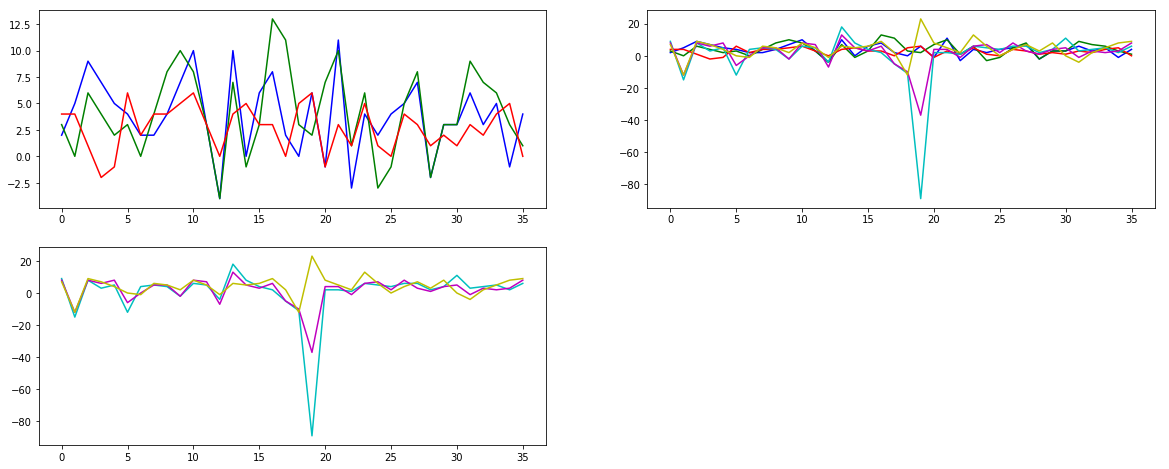

In [97]:
pad = 436961

fig, ax = plt.subplots(2, 2, figsize=(20, 8))
plt.grid(False)
ax[1, 1].axis('off')

ax[0, 0].plot(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][1308::4096], color='b') 
ax[0, 0].plot(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][1309::4096], color='g')
ax[0, 0].plot(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][1310::4096], color='r')

ax[1, 0].plot(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][2198::4096], color='c')
ax[1, 0].plot(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][2199::4096], color='m')
ax[1, 0].plot(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][2200::4096], color='y')

ax[0, 1].plot(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][1308::4096], color='b') 
ax[0, 1].plot(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][1309::4096], color='g')
ax[0, 1].plot(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][1310::4096], color='r')
ax[0, 1].plot(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][2198::4096], color='c')
ax[0, 1].plot(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][2199::4096], color='m')
ax[0, 1].plot(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][2200::4096], color='y')
        
plt.grid(False)

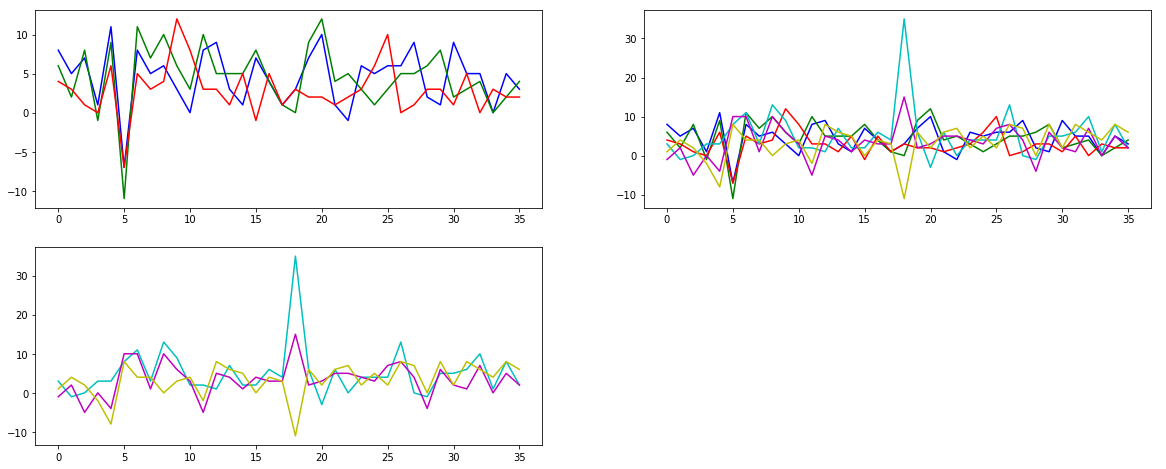

In [99]:

pad = 1000481
  
fig, ax = plt.subplots(2, 2, figsize=(20, 8))
plt.grid(False)
ax[1, 1].axis('off')

ax[0, 0].plot(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][3036::4096], color='b') 
ax[0, 0].plot(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][3037::4096], color='g')
ax[0, 0].plot(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][3038::4096], color='r')

ax[1, 0].plot(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][3396::4096], color='c')
ax[1, 0].plot(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][3397::4096], color='m')
ax[1, 0].plot(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][3398::4096], color='y')

ax[0, 1].plot(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][3036::4096], color='b') 
ax[0, 1].plot(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][3037::4096], color='g')
ax[0, 1].plot(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][3038::4096], color='r')
ax[0, 1].plot(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][3396::4096], color='c')
ax[0, 1].plot(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][3397::4096], color='m')
ax[0, 1].plot(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][3398::4096], color='y')
        
plt.grid(False)

in fact, we will identify breakpoint by delete max and min value.

In [113]:
def del_obj(a):
    return [np.argmax(a), np.argmin(a)]

for pad in [436961]:
    print(pad)
    print(f"Correct: {4096-(((pad + 4096) - 4094) % 4096)}")
    
    distances = []
    
    for i in range(4096-1):
        distances.append(
            calc_distances(
                np.delete(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][i::4096], obj=del_obj(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][i::4096])), 
                np.delete(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][i+1::4096], obj=del_obj(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][i+1::4096]))
            )
        )
        
    distances.append(
        calc_distances(
            np.delete(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx+1][i+1::4096], obj=del_obj(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx+1][i+1::4096])),
            np.delete(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx+1][(i+1)+1::4096], obj=del_obj(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx+1][(i+1)+1::4096]))
        )
    )
    
    breakpoints_0 = np.argsort(np.array(distances).T)[:,::-1][:,:20]
    
    distances = []
    
    for i in range(4096-1):
        distances.append(
            calc_distances(
                np.delete(aco.acoustic_data.values[pad:pad+seg_nrows][start_idx:][i::4096], obj=del_obj(aco.acoustic_data.values[pad:pad+seg_nrows][start_idx:][i::4096])),
                np.delete(aco.acoustic_data.values[pad:pad+seg_nrows][start_idx:][i+1::4096], obj=del_obj(aco.acoustic_data.values[pad:pad+seg_nrows][start_idx:][i+1::4096]))
            )
        )
        
    distances.append(
        calc_distances(
            np.delete(aco.acoustic_data.values[pad:pad+seg_nrows][start_idx-1:][i+1::4096], obj=del_obj(aco.acoustic_data.values[pad:pad+seg_nrows][start_idx-1:][i+1::4096])),
            np.delete(aco.acoustic_data.values[pad:pad+seg_nrows][start_idx-1:][(i+1)+1::4096], obj=del_obj(aco.acoustic_data.values[pad:pad+seg_nrows][start_idx-1:][(i+1)+1::4096]))
        )
    )
    
    breakpoints_1 = (start_idx + np.argsort(np.array(distances).T)[:,::-1][:,:20]) % 4096
    
    print(breakpoints_0, '\n',breakpoints_1)
    
    answer = 0
    if breakpoints_0[0][0] == breakpoints_0[1][0] == breakpoints_0[2][0]:
        answer = breakpoints_0[0][1]
    elif breakpoints_0[1][0] == breakpoints_0[2][0]:
        answer = breakpoints_0[1][0]
    else:
        answer = breakpoints_0[0][0]
    
    print(np.where(breakpoints_0[0] == (4096-(((pad + 4096) - 4094) % 4096))))
    print(((pad + answer) - 4094) % 4096)
    print("+"*10)

436961
Correct: 1309
[[2278  355 2279 2213 3169 2229 3922 1929 2221 2921 2230  379 1928  383 2215  714  353 2749  337 2209]
 [2221 2213 2279 2315 2209 2278 2170  355 2229 2177  330 2169 2214 2722  363 2720  353  315  361 2929]
 [2169 1310 1772 2246 2209 1349 2454 1824  814 2251  206 2627 3490 3848  910 3664  919 1293  588 1926]] 
 [[2279 2213 3169 2229 3922 2221 2921 2230  353 1929  714 2215 2209 2749 1928 3782 3055 1781  330 2214]
 [2221 2213 2279 2315 2209 2170 2229 2177  330 2169 2214 2722  363 2720  361  315 2929 3169 2860  353]
 [2169 1310 1772 2246 2209 1349 2251  206 1824 2454  814 2627 3490 1669 3848 1749 3664  182  757 2180]]
(array([], dtype=int64),)
969
++++++++++


Oh...  
Next, try clipping.

In [269]:
for pad in np.random.randint(0, high=1200_000-seg_nrows-1, size=4*5): #[436961]:
    print(pad)
    print(f"Correct: {4096-(((pad + 4096) - 4094) % 4096)}")
    
    distances = []
    
    for i in range(4096-1):
        distances.append(
            calc_distances(
                np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][i::4096], -10, 10),
                np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][i+1::4096], -10, 10)
            )
        )
        
    distances.append(
        calc_distances(
            np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx+1][i+1::4096], -10, 10),
            np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx+1][(i+1)+1::4096], -10, 10)
        )
    )
    
    breakpoints_0 = np.argsort(np.array(distances).T)[:,::-1][:,:50]
    
    distances = []
    
    for i in range(4096-1):
        distances.append(
            calc_distances(
                np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][start_idx:][i::4096], -10, 10),
                np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][start_idx:][i+1::4096], -10, 10)
            )
        )
        
    distances.append(
        calc_distances(
            np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][start_idx-1:][i+1::4096], -10, 10),
            np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][start_idx-1:][(i+1)+1::4096], -10, 10)
        )
    )
    
    breakpoints_1 = (start_idx + np.argsort(np.array(distances).T)[:,::-1][:,:100]) % 4096
    
    print(breakpoints_0)#, '\n',breakpoints_1)
    
    answer = 0
    if breakpoints_0[0][0] == breakpoints_0[1][0] == breakpoints_0[2][0]:
        answer = breakpoints_0[0][1]
    elif breakpoints_0[1][0] == breakpoints_0[2][0]:
        answer = breakpoints_0[1][0]
    else:
        answer = breakpoints_0[0][0]
    
    print(np.where(breakpoints_0[0] == (4096-(((pad + 4096) - 4094) % 4096))))
    print(((pad + answer) - 4094) % 4096)
    print("+"*10)

82487
Correct: 3527
[[3527 3149 1505 3585 1610 1469 3244 3539 1645  464 3616 2925 2586 3210 3211 2159  320 1732 2193 1073 2059  990 3569 1506 1503 1921 3903 1304 2010  170 3663 4048 1724 3817 3904 1742  686 3673 3608
  3207 2094 1504 1690 2963 4038 2118 3875  334 3434   46]
 [ 464 3527 4048 3554 1732 3244 1505 3149 3539 3578 1673 1803 3608  465 3970 1645 1610 3616 3585 3720 3569 2094 3663 4038 1573 3875 1016 2059 3639 1742 3562   46 2159 1773 3600  209 1469  320 2833
  3673 1506 4000 3869  665 2193 3810 4028 3624 1059 3207]
 [3012 2059 3244 3608 3639 1094 1773 1469 3220 2786 2010  170 2689  444 1764  996  923 3434 2221 1610 3578 1754 3528 2046 2127 1763 2997 2159 1373 1093 3532 1037 3207 3052 3592 2934 1742 3211  201
  1891 3701 2852 2345 2297 1886 1724 3793 2414 1636  522]]
(array([0], dtype=int64),)
0
++++++++++
908158
Correct: 1152
[[1152 1357 3944  138  855 1483  832 1755 1215  801  333 2262 1585 2151 1569 1366 3159 2685 1066 1404 2352 1687 3477 2152 1522 2944 1941 2732 1570 2843 3

  1841 1396 1884 1413  809 2991 3934 1679 3346 1647 3234]]
(array([0], dtype=int64),)
2060
++++++++++
409081
Correct: 517
[[ 517 3809 1540 1725 3959  199  523 2379 2578 1500  183 1106 3618 2958 1469  564 2577  940 3350 1423 3297 1407 3559   68 1528 1453  113 1556 2903 1060 2380 1031 1227 3883 3671 3834 1349 2388 3516
   214 2827 3064  773 2378 3323 2074  230 1241  494 3998]
 [1725 1540 3809 2578  517 2577 3618  113 2958 3959 3873 1510   68 3987 3615 1349  236 1241 1423 1525 1407  183 3867  214 3616 1500 1386 1715 3834 1556  208 4003 1453 2582 1431 2379 3559 3662 2975
  1360 1416  206 4011  337  134 3883 3866 1619   98  494]
 [1478  506 3834 1386   68  199  637  890 1431 2560 3845  557 3865  183 3618  707  134 3319  517 3798 3218  344 1061 3200 3929 3587 1031 2511  647 1510 2453  518 1857 2958 2170 2438 3427  607 2350
  2388  807 2135 1459 2134 3064  424  828  523 3847 3833]]
(array([0], dtype=int64),)
0
++++++++++
558364
Correct: 2786
[[2786 1797  748  747 3184 1001 3479 1612 3525 3383

  2236 1980 2588 3623 2216 2492 2287 2620   90 2246 1740]]
(array([0], dtype=int64),)
0
++++++++++


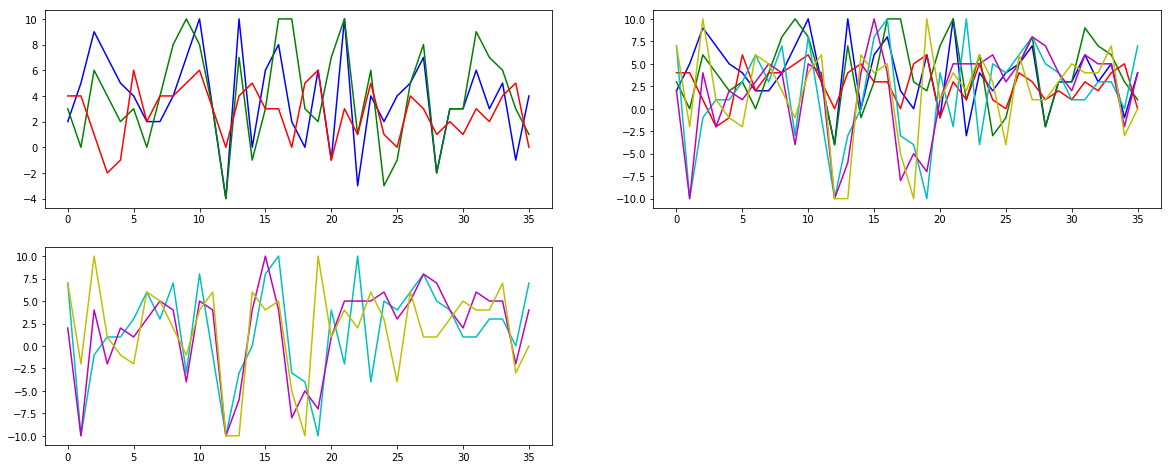

In [116]:
pad = 436961

correct = 1309
incorrect = 2215

fig, ax = plt.subplots(2, 2, figsize=(20, 8))
plt.grid(False)
ax[1, 1].axis('off')

ax[0, 0].plot(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][correct-1::4096],   -10, 10), color='b') 
ax[0, 0].plot(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][correct::4096],     -10, 10), color='g')
ax[0, 0].plot(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][correct+1::4096],   -10, 10), color='r')

ax[1, 0].plot(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][incorrect-1::4096], -10, 10), color='c')
ax[1, 0].plot(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][incorrect::4096],   -10, 10), color='m')
ax[1, 0].plot(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][incorrect+1::4096], -10, 10), color='y')

ax[0, 1].plot(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][correct-1::4096],   -10, 10), color='b') 
ax[0, 1].plot(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][correct::4096],     -10, 10), color='g')
ax[0, 1].plot(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][correct+1::4096],   -10, 10), color='r')
ax[0, 1].plot(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][incorrect-1::4096], -10, 10), color='c')
ax[0, 1].plot(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][incorrect::4096],   -10, 10), color='m')
ax[0, 1].plot(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][incorrect+1::4096], -10, 10), color='y')
        
plt.grid(False)

we need normalization.

In [268]:
def zscore(x, axis=None):
    xmean = x.mean(axis=axis, keepdims=True)
    xstd  = np.std(x, axis=axis, keepdims=True)
    zscore = (x-xmean)/xstd
    
    return zscore #np.convolve(signal.resample(zscore, 16) ,[0.5])

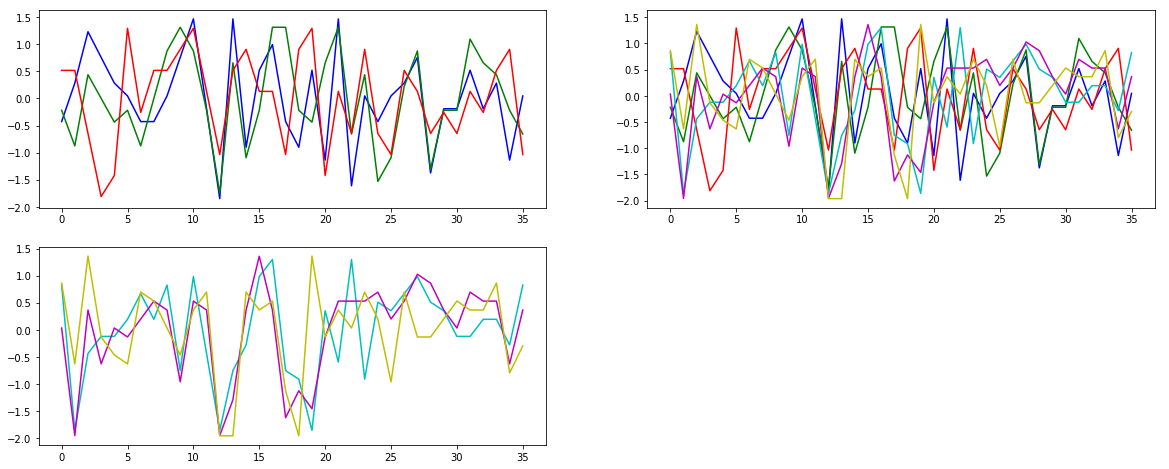

In [164]:
pad = 436961

correct = 1309
incorrect = 2215

fig, ax = plt.subplots(2, 2, figsize=(20, 8))
plt.grid(False)
ax[1, 1].axis('off')

ax[0, 0].plot(zscore(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][correct-1::4096]  ,   -10, 10)  ), color='b') 
ax[0, 0].plot(zscore(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][correct::4096]    ,   -10, 10)  ), color='g')
ax[0, 0].plot(zscore(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][correct+1::4096]  ,   -10, 10)  ), color='r')

ax[1, 0].plot(zscore(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][incorrect-1::4096],   -10, 10)  ), color='c')
ax[1, 0].plot(zscore(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][incorrect::4096]  ,   -10, 10)  ), color='m')
ax[1, 0].plot(zscore(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][incorrect+1::4096],   -10, 10)  ), color='y')

ax[0, 1].plot(zscore(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][correct-1::4096]  ,   -10, 10)  ), color='b') 
ax[0, 1].plot(zscore(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][correct::4096]    ,   -10, 10)  ), color='g')
ax[0, 1].plot(zscore(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][correct+1::4096]  ,   -10, 10)  ), color='r')
ax[0, 1].plot(zscore(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][incorrect-1::4096],   -10, 10)  ), color='c')
ax[0, 1].plot(zscore(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][incorrect::4096]  ,   -10, 10)  ), color='m')
ax[0, 1].plot(zscore(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][incorrect+1::4096],   -10, 10)  ), color='y')
          
plt.grid(False)

In [260]:
def calc_distances(a, b):
    return [distance.cosine(a, b), distance.euclidean(a, b), 1-metrics.r2_score(a, b)] #, lb_keogh(ts_query=b, ts_candidate=a, radius=1)]

In [ ]:
from IPython.display import clear_output
import time

"""
for j, pad in  enumerate(np.random.randint(0, high=1200_000-seg_nrows-1, size=100)): # [436961]:
    print(pad)
    print(f"Correct: {4096-(((pad + 4096) - 4094) % 4096)}")
    
    distances = []
    
    for i in range(4096-1):
        distances.append(
            calc_distances(
                zscore(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][i::4096], -10, 10)),
                zscore(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][i+1::4096], -10, 10))
            )
        )
        
    distances.append(
        calc_distances(
            zscore(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx+1][i+1::4096], -10, 10)),
            zscore(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx+1][(i+1)+1::4096], -10, 10))
        )
    )
    
    breakpoints_0 = np.argsort(np.array(distances).T)[:,::-1][:,:20]

    # distances = []
    # 
    # for i in range(4096-1):
    #     distances.append(
    #         calc_distances(
    #             zscore(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][start_idx:][i::4096], -10, 10)),
    #             zscore(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][start_idx:][i+1::4096], -10, 10))
    #         )
    #     )
    #     
    # distances.append(
    #     calc_distances(
    #         zscore(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][start_idx-1:][i+1::4096], -10, 10)),
    #         zscore(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][start_idx-1:][(i+1)+1::4096], -10, 10))
    #     )
    # )
    # 
    # breakpoints_1 = (start_idx + np.argsort(np.array(distances).T)[:,::-1][:,:50]) % 4096

    print(breakpoints_0)#, '\n\n\n',breakpoints_1)
    
    answer = 0
    if breakpoints_0[0][0] == breakpoints_0[1][0] == breakpoints_0[2][0]:
        answer = breakpoints_0[0][1]
    elif breakpoints_0[1][0] == breakpoints_0[2][0]:
        answer = breakpoints_0[1][0]
    else:
        answer = breakpoints_0[0][0]
    
    print(np.where(breakpoints_0[0] == (4096-(((pad + 4096) - 4094) % 4096))))
    print(((pad + answer) - 4094) % 4096)
    #print("+"*10)
    
    if 0==(j+1)%4:
        time.sleep(0.5)
        clear_output()
"""

✓ Clipping  
✓ Normalization

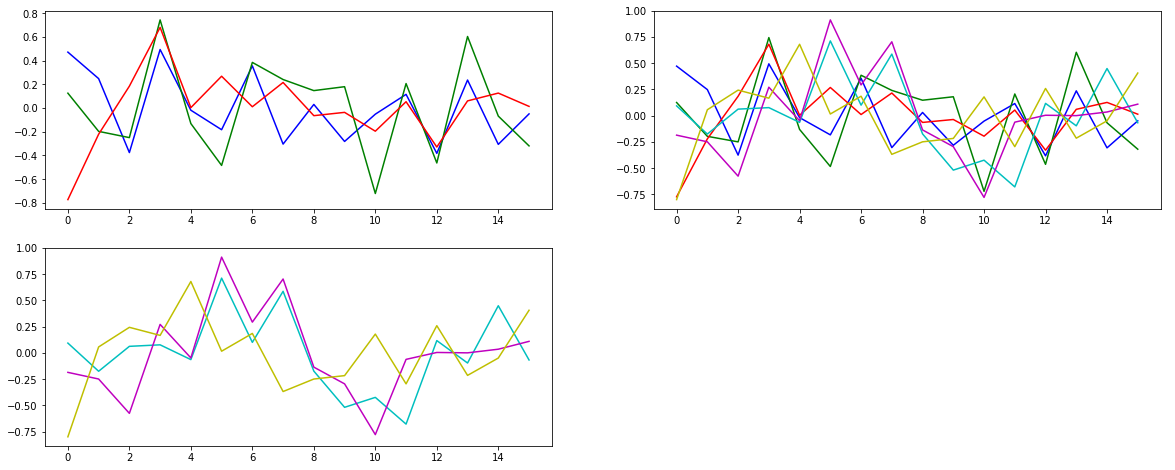

In [259]:
pad = 443727#436961


correct = 2735#1309
incorrect = 3278#243

fig, ax = plt.subplots(2, 2, figsize=(20, 8))
plt.grid(False)
ax[1, 1].axis('off')

ax[0, 0].plot(zscore(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][correct-1::4096]  ,   -10, 10)  ), color='b') 
ax[0, 0].plot(zscore(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][correct::4096]    ,   -10, 10)  ), color='g')
ax[0, 0].plot(zscore(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][correct+1::4096]  ,   -10, 10)  ), color='r')

ax[1, 0].plot(zscore(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][incorrect-1::4096],   -10, 10)  ), color='c')
ax[1, 0].plot(zscore(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][incorrect::4096]  ,   -10, 10)  ), color='m')
ax[1, 0].plot(zscore(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][incorrect+1::4096],   -10, 10)  ), color='y')

ax[0, 1].plot(zscore(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][correct-1::4096]  ,   -10, 10)  ), color='b') 
ax[0, 1].plot(zscore(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][correct::4096]    ,   -10, 10)  ), color='g')
ax[0, 1].plot(zscore(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][correct+1::4096]  ,   -10, 10)  ), color='r')
ax[0, 1].plot(zscore(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][incorrect-1::4096],   -10, 10)  ), color='c')
ax[0, 1].plot(zscore(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][incorrect::4096]  ,   -10, 10)  ), color='m')
ax[0, 1].plot(zscore(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][incorrect+1::4096],   -10, 10)  ), color='y')

plt.grid(False)

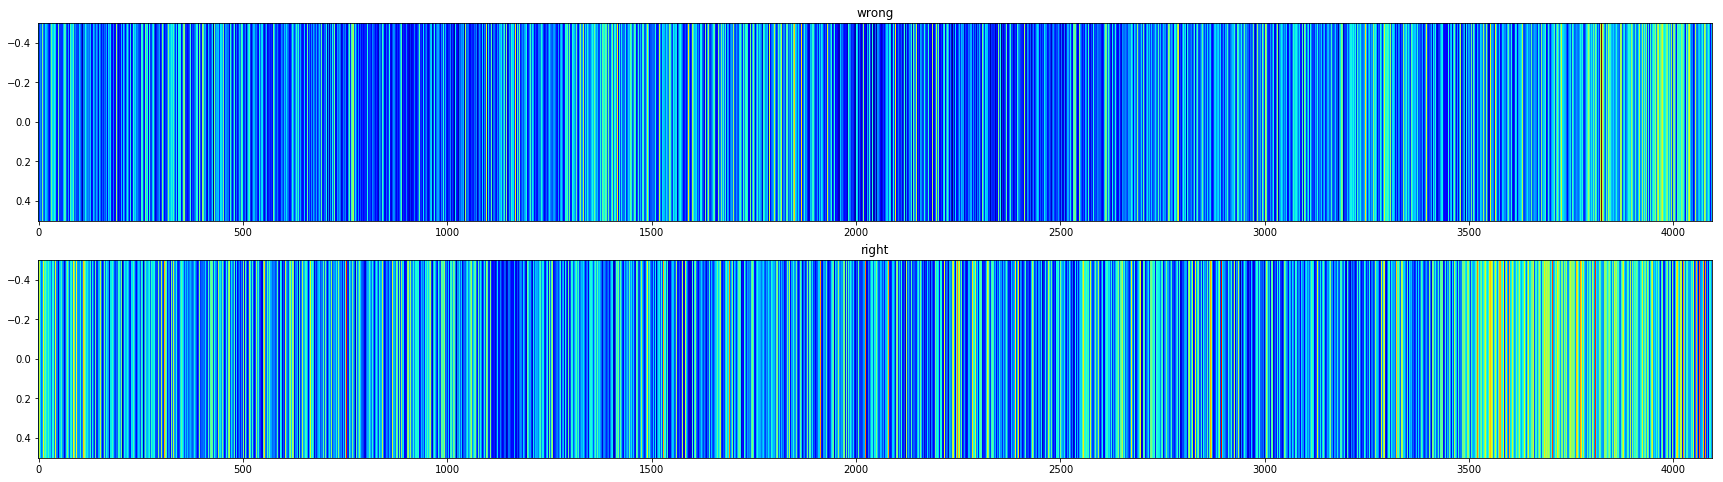

In [283]:


fig, ax = plt.subplots(2, 1, figsize=(30,8))

for j, (tag, pad) in enumerate({"wrong": 985345, "right": 223299}.items()): #correct 1789, 1979

    distances = []
    
    for i in range(4096-1):
        distances.append(
            distance.cosine(
                zscore(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][i::4096], -10, 10)  ) ,
                zscore(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx][i+1::4096], -10, 10))
            )
        )
        
    distances.append(
        distance.cosine(
            zscore(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx+1][i+1::4096], -10, 10)),
            zscore(np.clip(aco.acoustic_data.values[pad:pad+seg_nrows][:end_idx+1][(i+1)+1::4096], -10, 10))
        )
    )
    ax[j].set_title(tag)
    ax[j].imshow(np.array(distances)[np.newaxis,:], cmap="jet", aspect="auto")